# MAST30034 Project 1
## Analysis

In [1]:
from functools import reduce 
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/15 21:23:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/15 21:23:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
import pandas as pd
import geopandas as gpd
import folium
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import *

/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [16]:
taxi = spark.read.parquet('../data/curated/taxi')
weather = spark.read.parquet('../data/curated/weather')
taxi = taxi.withColumn("pickup_date",to_date(col("pickup_time")))
taxi = taxi.drop("pickup_time", "dropoff_time")
sdf = taxi.join(weather,taxi.pickup_date ==  weather.date,"inner")
sdf = sdf.drop('date')
sdf.write.parquet("../data/curated/combined")

In [58]:
df = pd.read_parquet('../data/curated/combined')
non_zero_tips = df.drop(df[df.tip_amount == 0].index)
non_zero_tips.to_parquet('../data/curated/combined_non_zero', compression='gzip')


### Geopandas visualisation
#### Average tip earnings per taxi zone

In [207]:
sf = gpd.read_file("../data/raw/taxi_zones.shp")
zones = pd.read_csv("../data/raw/taxi+_zone_lookup.csv")
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)
geoJSON = gdf[['LocationID', 'geometry']].drop_duplicates('LocationID').to_json()


In [215]:
sdf = spark.read.parquet('../data/curated/taxi')
geo_tips = sdf[['pickup_location', 'tip_amount']] \
                .groupby('pickup_location') \
                .agg(
                    {
                        'tip_amount': 'sum', # sum over total amount earned
                        'pickup_location': 'count' # count number of instances from sample
                    }
                )
geo_tips = geo_tips.withColumn('avg_tip_amount', geo_tips['sum(tip_amount)'] / geo_tips['count(pickup_location)'])
geo_tips = geo_tips.withColumnRenamed('count(pickup_location)', 'total_trips').withColumnRenamed('sum(tip_amount)', 'total_tips')
df = geo_tips.toPandas()
print(df)
df = df \
    .merge(gdf[['LocationID', 'geometry']], left_on='pickup_location', right_on='LocationID') \
    .drop('LocationID', axis=1)

     pickup_location  total_trips  total_tips  avg_tip_amount
0                 29        12210     5886.95        0.482142
1                 26        23863     6504.17        0.272563
2                 65       211146   492747.78        2.333683
3                191        11441     2329.80        0.203636
4                222        14559     3627.65        0.249169
..               ...          ...         ...             ...
255               13            4       15.66        3.915000
256              125            6        0.00        0.000000
257              261           16       14.06        0.878750
258              199            1        0.01        0.010000
259              211            2        0.00        0.000000

[260 rows x 4 columns]


In [216]:
df['avg_tip_amount'].idxmax()
df.sort_values("pickup_location")

,pickup_location,total_trips,total_tips,avg_tip_amount,geometry
103,1,38,634.15,16.688158,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
166,2,5,3.56,0.712000,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
146,3,8821,2126.24,0.241043,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
180,4,21,6.73,0.320476,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
102,5,88,30.89,0.351023,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...
231,259,9201,2134.37,0.231972,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
164,260,117517,257439.23,2.190655,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
255,261,16,14.06,0.878750,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."
25,262,241,987.76,4.098589,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ..."


There is one major outlier in the dataset, this is pickup location 1, lets look into all occurances of location 1 to see any outliers that may be effecting the data:

In [220]:
combined = pd.read_parquet('../data/curated/combined')
combined = combined.drop(combined[combined.pickup_location != 1].index)
combined


,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry,centroid
0,1,EWR,Newark Airport,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...","(40.69183120640148, -74.17400027276294)"
1,2,Queens,Jamaica Bay,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...","(40.61674529165989, -73.83129854302217)"
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...","(40.864473684775454, -73.84742223236714)"
3,4,Manhattan,Alphabet City,Yellow Zone,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...","(40.723752141584804, -73.97696825691766)"
4,5,Staten Island,Arden Heights,Boro Zone,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...","(40.55265928694568, -74.1884841018493)"
...,...,...,...,...,...,...,...,...,...,...,...
258,259,Bronx,Woodlawn/Wakefield,Boro Zone,259,0.126750,0.000395,Woodlawn/Wakefield,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...","(40.89793202529465, -73.85221545370119)"
259,260,Queens,Woodside,Boro Zone,260,0.133514,0.000422,Woodside,Queens,"POLYGON ((-73.90175 40.76078, -73.90147 40.759...","(40.74423471780147, -73.90630644197877)"
260,261,Manhattan,World Trade Center,Yellow Zone,261,0.027120,0.000034,World Trade Center,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...","(40.709138940671856, -74.013022771749)"
261,262,Manhattan,Yorkville East,Yellow Zone,262,0.049064,0.000122,Yorkville East,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...","(40.775932403149945, -73.94651035601463)"


Looking at the occurances, doesnt show any clear outliers, thus we shal look at if there is anything significant about the location:

In [232]:
map = folium.Map(location=[40.73, -73.74], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='Average Tip Earnings (USD)', # name of plot
    data=df, # data source
    columns=['pickup_location','avg_tip_amount'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    legend_name='Average Tip Earnings (USD)'
)
c.add_to(map)

gdf['centroid'] = gdf['geometry'].apply(lambda x: (x.centroid.y, x.centroid.x))
gdf[['Zone', 'LocationID', 'centroid']].head()
for zone_name, coord in gdf.loc[gdf['Zone'].str.contains('Airport'), ['Zone', 'centroid']].values:
    map.add_child(
        folium.Marker(location=coord, popup=zone_name)
    )
for zone_name, coord in gdf.loc[gdf['Zone'].str.contains('Flushing Meadows'), ['Zone', 'centroid']].values:
    map.add_child(
        folium.Marker(location=coord, popup=zone_name)
    )
map
map.save("../plots/Distribution_of_Tips_Across_NYC.html")

The above shows the distribution of tips across NYC, the top 4 tipping locations have been marked, and correpsond with the 3 major airports in NYC as well as flushing meadows which is home to the USTA Billie Jean King National Tennis Center (US Open) and City Field (NY Mets home stadium).

### Frequency of particular tip amounts

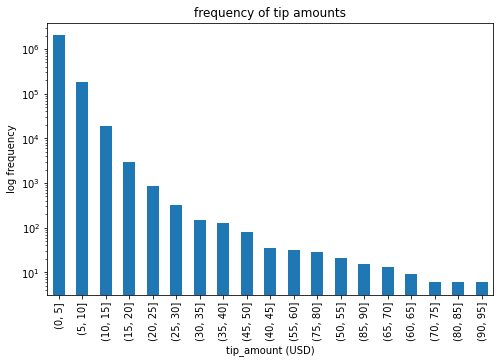

In [234]:
import pandas as pd
df = pd.read_parquet("../data/curated/combined")
df['binned'] = pd.cut(df["tip_amount"], bins= range(0, 100, 5))
fig, ax = plt.subplots(figsize=(8,5))
ax = df['binned'].value_counts().plot(kind='bar', logy = True, title = 'frequency of tip amounts')
ax.set_ylabel("log frequency")
ax.set_xlabel("tip_amount (USD)")
fig.savefig('../plots/Frequency_of_tips_amounts.png')

In [12]:
pctge_non_zero_tips = ((df['tip_amount'] == 0).sum() / df['tip_amount'].count())*100
pctge_non_zero_tips


34.22136873947701

### Correlation Matrix

22/08/16 08:51:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/08/16 08:51:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


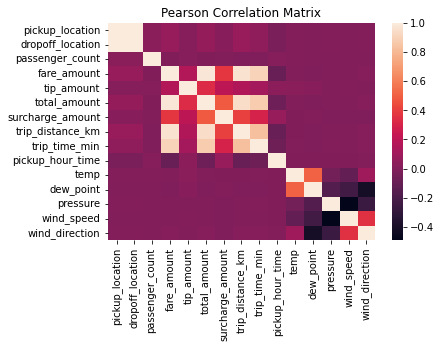

In [17]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns

sdf = spark.read.parquet("../data/curated/combined")
cor_sdf = sdf.drop('pickup_date')
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cor_sdf.columns, outputCol=vector_col)
df_vector = assembler.transform(cor_sdf).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

sns.heatmap(corrmatrix, yticklabels = cor_sdf.columns, xticklabels = cor_sdf.columns)
plt.title('Pearson Correlation Matrix')
plt.show()

From a tipping perspective, we can see that the main categories it is correlated with is fare_amount, total_amount and surcharge_amount, this is obvious as total_amount is the some of the other 3. (pickup_location, dropoff_location) and (temp, dew_point) are pairs heavily correlated (with reality supporting this finding. To see which metrics are correlated with tipping, the variables mentioned wil be dropped:

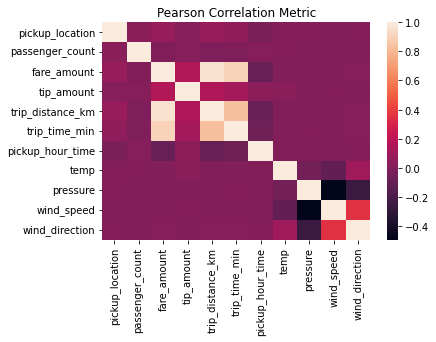

In [18]:
cor_sdf = sdf.drop('dropoff_location', 'dew_point', 'pickup_date', 'total_amount', 'surcharge_amount')
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cor_sdf.columns, outputCol=vector_col)
df_vector = assembler.transform(cor_sdf).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

sns.heatmap(corrmatrix, yticklabels = cor_sdf.columns, xticklabels = cor_sdf.columns)
plt.title('Pearson Correlation Metric')
plt.show()

It appears as though, fare amount, trip distance and trip time are the most correlated variables with tipping, These will be further investigated. To check if there is any other weeker correlations, we will remove these:

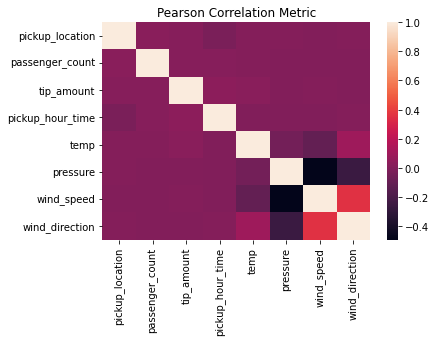

In [19]:
cor_sdf = sdf.drop('dropoff_location', 'dew_point', 'pickup_date', 'total_amount', 'surcharge_amount', 'fare_amount', 'trip_distance_km', 'trip_time_min')
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cor_sdf.columns, outputCol=vector_col)
df_vector = assembler.transform(cor_sdf).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

sns.heatmap(corrmatrix, yticklabels = cor_sdf.columns, xticklabels = cor_sdf.columns)
plt.title('Pearson Correlation Metric')
plt.show()

Very faintly you can see that temp is slightly correlated with tip amount. thus it will also be investigated:

### Tip_amount vs fare_amount:

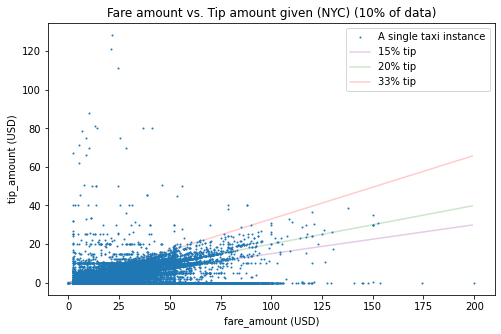

In [20]:
df = pd.read_parquet("../data/curated/combined")
df = df.sample(frac=0.10, replace=True, random_state=1)
x = df['fare_amount']
y = df['tip_amount']
line = range(200)
tip_15_line = [0.15*x for x in range(200)]
tip_20_line = [0.20*x for x in range(200)]
tip_33_line = [0.33*x for x in range(200)]
fig, ax = plt.subplots(figsize=(8,5))
fare_df = pd.DataFrame({"x": x, "y":y})
#You pass the wanted axis to the ax argument
fare_df.plot(kind='scatter', x= 'x', y= 'y', s = 1, title="Fare amount vs. Tip amount given (NYC) (10% of data)", ax=ax) 
ax.plot(line, tip_15_line, zorder=-1, color = 'purple', alpha = 0.2)
ax.plot(line, tip_20_line, zorder=-1, color = 'green', alpha = 0.2)
ax.plot(line, tip_33_line, zorder=-1, color = 'red', alpha = 0.2)
ax.set_xlabel("fare_amount (USD)")
ax.set_ylabel("tip_amount (USD)")
plt.legend(['A single taxi instance', '15% tip', '20% tip', '33% tip'])

In [21]:
df = pd.read_parquet("../data/curated/combined")
df['between_15_and_33'] = np.where((df['tip_amount'] >= df['fare_amount']*0.15) & (df['tip_amount'] <= df['fare_amount']*0.33), True, False)
perc_between_15_and_33 = (df.between_15_and_33.value_counts().loc[True] / df.between_15_and_33.count())*100
perc_between_15_and_33

51.88691877592178

In [22]:
df = pd.read_parquet("../data/curated/combined")
df = df.drop(df[df.tip_amount == 0].index)
df['between_15_and_33'] = np.where((df['tip_amount'] >= df['fare_amount']*0.15) & (df['tip_amount'] <= df['fare_amount']*0.33), True, False)
perc_between_15_and_33 = (df.between_15_and_33.value_counts().loc[True] / df.between_15_and_33.count())*100
perc_between_15_and_33

78.88111652919369

The above output shows the distribution of fare amount verses the tip given, two lines representing 10% and 20% tip (% of fare amount) have been overlaid, due to the extremely large datset, 10% was used for graph, which showed the relationship alot better. Visable from this (and the above calculation, majority (~52%) of tips are between 15 and 33% of the fare amount. if you only include people who tipped a non zero amount, this number rises to ~79%

### Tip amounnt vs Trip_distance

slope, intercept, r^2 = 0.3312205327128886 1.1467870798828548 0.5832158802940952


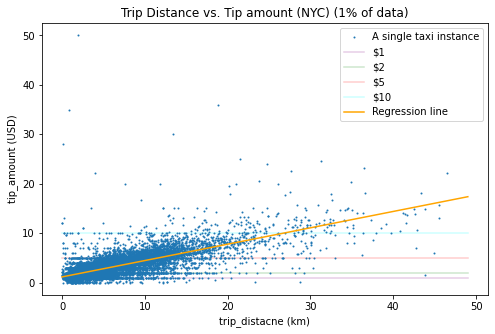

In [36]:
import scipy.stats 
df = pd.read_parquet("../data/curated/combined")
df_non_zero_tips = df.drop(df[df.tip_amount == 0].index)
df_non_zero_tips = df_non_zero_tips.sample(frac=0.01, replace=True, random_state=1)
x = df_non_zero_tips['trip_distance_km']
y = df_non_zero_tips['tip_amount']
fig, ax = plt.subplots(figsize=(8,5))
distance_df = pd.DataFrame({"x": x, "y":y})
line = range(50)
tip_1usd = [1 for x in range(50)]
tip_2usd = [2 for x in range(50)]
tip_5usd = [5 for x in range(50)]
tip_10usd = [10 for x in range(50)]
p = np.poly1d(np.polyfit(x, y, 1))
tip_reg = [p(x) for x in range(50)]
#You pass the wanted axis to the ax argument
distance_df.plot(kind='scatter', x= 'x', y= 'y', s = 1, title="Trip Distance vs. Tip amount (NYC) (1% of data)", ax=ax) 
ax.plot(line, tip_1usd, zorder=-1, color = 'purple', alpha = 0.2)
ax.plot(line, tip_2usd, zorder=-1, color = 'green', alpha = 0.2)
ax.plot(line, tip_5usd, zorder=-1, color = 'red', alpha = 0.2)
ax.plot(line, tip_10usd, zorder=-1, color = 'aqua', alpha = 0.2)
ax.plot(line, tip_reg, zorder=1, color = 'orange')
ax.set_xlabel("trip_distacne (km)")
ax.set_ylabel("tip_amount (USD)")
plt.legend(['A single taxi instance', '$1', '$2', '$5', '$10', 'Regression line'])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("slope, intercept, r^2 =", slope, intercept, r_value**2)

The above output shows the relationship between Trip distance and tips give, three lines representing 1, 2, 5 and 10 dollars have been overlaid as well as a line of regression, to better see this relationship, 1% of thr data was graphed. The output shows that people often will tip whole number dollars, however tips of one and two dollars are slightly more common when the trip distance is shorter compared to tipping 5 and 10 dollars. A regression line has also been fitted to show that there is a clear correlation (r^2 = 0.58) between distance and tips with approximately 33c being given for every kilometer driven, startng with approximately $1.10 at the start of the trip.

### Tip Amount vs Time Travelled

slope, intercept, r^2 = 0.13969073205921795 0.7940918527190504 0.5070787203797881


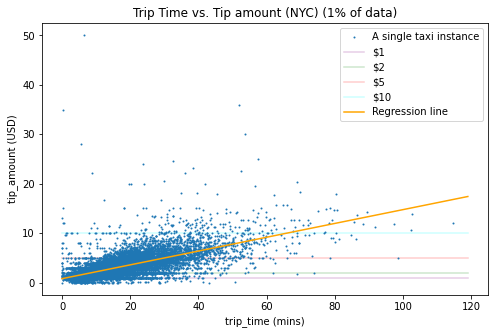

In [37]:
df = pd.read_parquet("../data/curated/combined")
df_non_zero_tips = df.drop(df[df.tip_amount == 0].index)
df_non_zero_tips = df_non_zero_tips.sample(frac=0.01, replace=True, random_state=1)
x = df_non_zero_tips['trip_time_min']
y = df_non_zero_tips['tip_amount']
fig, ax = plt.subplots(figsize=(8,5))
time_df = pd.DataFrame({"x": x, "y":y})
line = range(120)
tip_1usd = [1 for x in range(120)]
tip_2usd = [2 for x in range(120)]
tip_5usd = [5 for x in range(120)]
tip_10usd = [10 for x in range(120)]
p = np.poly1d(np.polyfit(x, y, 1))
tip_reg = [p(x) for x in range(120)]
#You pass the wanted axis to the ax argument
time_df.plot(kind='scatter', x= 'x', y= 'y', s = 1, title="Trip Time vs. Tip amount (NYC) (1% of data)", ax=ax) 
ax.plot(line, tip_1usd, zorder=-1, color = 'purple', alpha = 0.2)
ax.plot(line, tip_2usd, zorder=-1, color = 'green', alpha = 0.2)
ax.plot(line, tip_5usd, zorder=-1, color = 'red', alpha = 0.2)
ax.plot(line, tip_10usd, zorder=-1, color = 'aqua', alpha = 0.2)
ax.plot(line, tip_reg, zorder=1, color = 'orange')
ax.set_xlabel("trip_time (mins)")
ax.set_ylabel("tip_amount (USD)")
plt.legend(['A single taxi instance', '$1', '$2', '$5', '$10', 'Regression line'])
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("slope, intercept, r^2 =", slope, intercept, r_value**2)

The above output shows the relationship between Trip time and tips give, three lines representing 1, 2, 5 and 10 dollars have been overlaid as well as a line of regression. To better see this relationship, 1% of thr data was graphed. The output shows that people often will tip whole number dollars, however tips of one and two dollars are slightly more common when the trip distance is shorter compared to tipping 5 and 10 dollars. A regression line has also been fitted to show that there is a clear correlation (r^2 = 0.51) between time and tips with approximately 13c being given for every min driven, startng with approximately 79c at the start of the trip.

### Tips vs Temp

slope, intercept, r^2 = 0.0005683844037552284 0.6283254738658077 0.0811098992311558


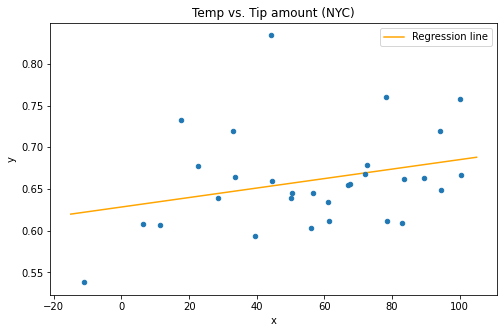

In [191]:
df = pd.read_parquet("../data/curated/combined")
all_df = df.groupby('temp')['tip_amount'].count()
nonzero_df = df.drop(df[df.tip_amount == 0].index)
nonzero_df = nonzero_df.groupby('temp')['tip_amount'].count()
all_df = all_df.to_frame().reset_index()
nonzero_df = nonzero_df.to_frame().reset_index()
nonzero_df['ratio'] = nonzero_df["tip_amount"] / all_df["tip_amount"]

x = nonzero_df['temp']
y = nonzero_df['ratio']
fig, ax = plt.subplots(figsize=(8,5))
temp_df = pd.DataFrame({"x": x, "y":y})

line = range(-15, 106)
p = np.poly1d(np.polyfit(x, y, 1))
tip_reg = [p(x) for x in range(-15, 106)]
ax.set_xlabel("Temp (F)")
ax.set_ylabel("Tipped : Didn't Tip")
ax.plot(line, tip_reg, zorder=1, color = 'orange')
temp_df.plot(kind='scatter', x= 'x', y= 'y', title="Temp vs. Tip amount (NYC)", ax=ax) 
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print("slope, intercept, r^2 =", slope, intercept, r_value**2)
plt.legend(['Regression line'])

### Tips vs Time of Day

Text(0, 0.5, "Tipped : Didn't Tip")

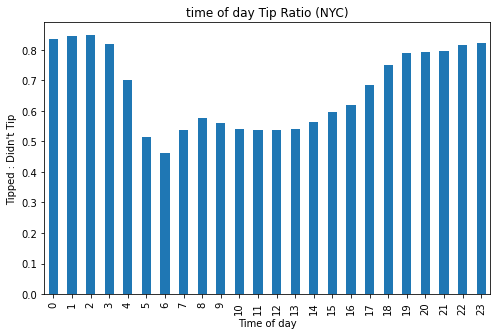

In [167]:
df = pd.read_parquet("../data/curated/combined")
all_df = df.groupby('pickup_hour_time')['tip_amount'].count()
nonzero_df = df.drop(df[df.tip_amount == 0].index)
nonzero_df = nonzero_df.groupby('pickup_hour_time')['tip_amount'].count()
all_df = all_df.to_frame().reset_index()
nonzero_df = nonzero_df.to_frame().reset_index()
nonzero_df['ratio'] = nonzero_df["tip_amount"] / all_df["tip_amount"]

x = nonzero_df['pickup_hour_time']
y = nonzero_df['ratio']
fig, ax = plt.subplots(figsize=(8,5))
time_df = pd.DataFrame({"Time of Day": x, "Tip Ratio":y})

time_df.plot(kind='bar', x= 'Time of Day', y= 'Tip Ratio', title="time of day Tip Ratio (NYC)", ax=ax, legend = False) 
ax.set_xlabel("Time of day")
ax.set_ylabel("Tipped : Didn't Tip")

Text(0, 0.5, 'Average tip amount (USD)')

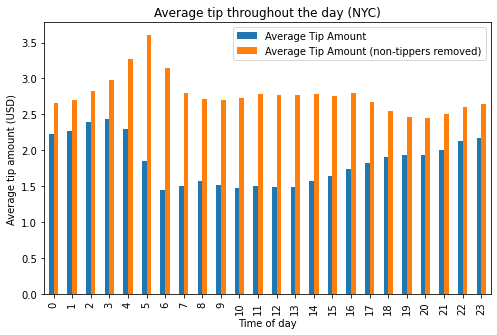

In [161]:
ToD = spark.read.parquet("../data/curated/combined")
ToD = ToD[['pickup_hour_time', 'tip_amount']] \
                .groupby('pickup_hour_time') \
                .agg(
                    {
                        'tip_amount': 'sum', # sum over total amount earned
                        'pickup_hour_time': 'count' # count number of instances from sample
                    }
                )
ToD = ToD.withColumn('avg_tip_amount', ToD['sum(tip_amount)'] / ToD['count(pickup_hour_time)'])
ToD = ToD.withColumnRenamed('count(pickup_hour_time)', 'total_trips').withColumnRenamed('sum(tip_amount)', 'total_tips')
ToD = ToD.toPandas()
ToD = ToD.sort_values(by=['pickup_hour_time']).reset_index(drop = True)

non_zero = spark.read.parquet("../data/curated/combined_non_zero")
ToD_zero = non_zero[['pickup_hour_time', 'tip_amount']] \
                .groupby('pickup_hour_time') \
                .agg(
                    {
                        'tip_amount': 'sum', # sum over total amount earned
                        'pickup_hour_time': 'count' # count number of instances from sample
                    }
                )
ToD_zero = ToD_zero.withColumn('avg_tip_amount', ToD_zero['sum(tip_amount)'] / ToD_zero['count(pickup_hour_time)'])
ToD_zero = ToD_zero.withColumnRenamed('count(pickup_hour_time)', 'total_trips').withColumnRenamed('sum(tip_amount)', 'total_tips')
ToD_zero = ToD_zero.toPandas()
ToD_zero = ToD_zero.sort_values(by=['pickup_hour_time']).reset_index(drop = True)

df = pd.read_parquet("../data/curated/combined")
all_df = df.groupby('pickup_hour_time')['tip_amount'].count()
nonzero_df = df.drop(df[df.tip_amount == 0].index)
nonzero_df = nonzero_df.groupby('pickup_hour_time')['tip_amount'].count()
all_df = all_df.to_frame().reset_index()
nonzero_df = nonzero_df.to_frame().reset_index()
nonzero_df['ratio'] = nonzero_df["tip_amount"] / all_df["tip_amount"]

ratio = nonzero_df['ratio']
tip_amount = ToD['avg_tip_amount']
tip_non_zero = ToD_zero['avg_tip_amount']
index = df['pickup_hour_time']
df = pd.DataFrame({'Average Tip Amount': tip_amount, 
                   'Average Tip Amount (non-tippers removed)': tip_non_zero}, index=index)
df = df.drop_duplicates().reset_index().sort_values(by=['pickup_hour_time']).set_index('pickup_hour_time')
fig, ax = plt.subplots(figsize=(8,5))
ax = df.plot.bar(title="Average tip throughout the day (NYC)", ax = ax)
ax.set_xlabel("Time of day")
ax.set_ylabel("Average tip amount (USD)")